In [89]:
from dotenv import load_dotenv
load_dotenv()

True

In [90]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [91]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model='text-embedding-3-small')

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name='restaurant_menu',
    persist_directory='./chroma_db'
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [92]:
from typing import List

class MenuState(TypedDict):
    user_query: str
    is_menu_related: bool
    search_results: List[str]
    final_answer: str

In [93]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [94]:
def get_user_query(state: MenuState) -> MenuState:
    user_query = input('무엇을 도와드릴까요?')
    return {'user_query': user_query}


def analyze_input(state: MenuState) -> MenuState:
    analyze_template = '''
    사용자의 입력을 분석하여 레스토랑 메뉴 추천이나 음식 정보에 관한 질문인지 판단하세요.

    사용자 입력: {user_query}

    레스토랑 메뉴나 음식 정보에 관한 질문이면 "True", 아니면 "False"로 답변 하세요.

    답변:
    '''

    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()

    result = analyze_chain.invoke({'user_query': state['user_query']})
    is_menu_related = result.strip().lower() == 'true'

    return {'is_menu_related': is_menu_related}


def search_menu_info(state: MenuState) -> MenuState:
    results = menu_db.similarity_search(state['user_query'], k=2)
    search_results = [doc.page_content for doc in results]

    return {'search_results': search_results}

In [95]:
def generate_menu_response(state: MenuState) -> MenuState:
    response_template = '''
    사용자 입력: {user_query}
    메뉴 관련 검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 메뉴 관련 질문에 대한 상세한 답변을 생성 하세요.
    검색 결과의 정보를 활용하여 유용한 정보를 제공하세요.

    답변:
    '''

    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()

    final_answer = response_chain.invoke({'user_query': state['user_query'],
                                          'search_results': state['search_results']})
    
    print(f'\n 메뉴 어시스턴트: {final_answer}')
    
    return {'final_answer': final_answer}

def generate_general_response(state: MenuState) -> MenuState:
    response_template = '''
    사용자 입력: {user_query}
    
    위 입력은 레스토랑 메뉴나 음식과 관련이 없습니다.
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.

    답변:
    '''

    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()

    final_answer = response_chain.invoke({'user_query': state['user_query']})

    print(f'\n 메뉴 어시스턴트: {final_answer}')
    
    return {'final_answer': final_answer}

In [96]:
from typing import Literal

def decide_next_step(state: MenuState) -> Literal['search_menu_info', 'generate_general_response']:
    if state['is_menu_related']:
        return 'search_menu_info'
    else:
        return 'generate_general_response'

In [97]:
builder = StateGraph(MenuState)

builder.add_node('get_user_query', get_user_query)
builder.add_node('analyze_input', analyze_input)
builder.add_node('search_menu_info', search_menu_info)
builder.add_node('generate_menu_response', generate_menu_response)
builder.add_node('generate_general_response', generate_general_response)

builder.add_edge(START, 'get_user_query')
builder.add_edge('get_user_query', 'analyze_input')

builder.add_conditional_edges(
    'analyze_input',
    decide_next_step,
    {
        'search_menu_info': 'search_menu_info',
        'generate_general_response': 'generate_general_response'
    }
)

builder.add_edge('search_menu_info', 'generate_menu_response')
builder.add_edge('generate_menu_response', END)
builder.add_edge('generate_general_response', END)

graph = builder.compile()

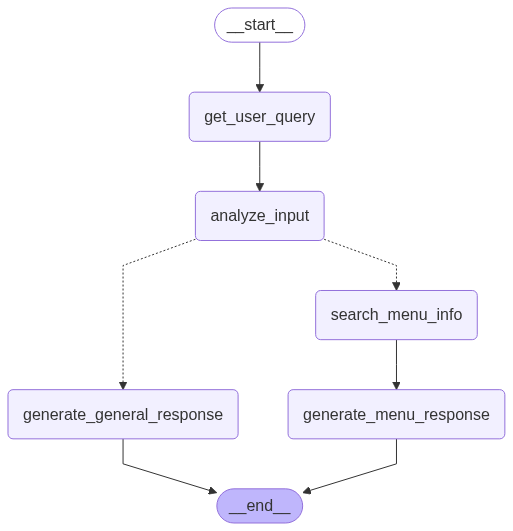

In [98]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [99]:
while True:
    init_state = {'user_query': ''}
    graph.invoke(init_state)
    continue_chat = input('다른 질문이 있으신가요?(y/n): ').lower()
    if continue_chat != 'y':
        print('종료')
        break


 메뉴 어시스턴트: 시그니처 스테이크는 가격이 ₩35,000이며, 다음과 같은 특징이 있습니다:

- **주요 식재료**: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
- **설명**: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용하여 미디엄 레어로 조리합니다. 이렇게 조리된 스테이크는 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여져 풍미를 더합니다. 또한, 레드와인 소스와 함께 제공되어 더욱 풍부한 맛을 경험할 수 있습니다.

이 메뉴는 고급스러운 식사를 원하시는 분들께 추천드립니다.
종료
